Dependecies and collecting images using openCV

In [1]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [14]:
import matplotlib.pyplot as plt
import json
import numpy as np


In [3]:
import os
import time
import uuid
import cv2


In [4]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 50

In [ ]:
import cv2
cap = cv2.VideoCapture(0)
# Check if the camera opened successfully
if not cap.isOpened():
    print("Error opening video stream or file")
    exit() 

for imgnum in range(number_images):
  print('Collecting image {}'.format(imgnum))
  ret, frame = cap.read()
  # Check if a frame was successfully read
  if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break
  imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname, frame)
  cv2.imshow('frame', frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

In [13]:
!labelme

Review dataset and build image loading function

In [16]:
gpu = tf.config.list_physical_devices('GPU')
len(gpu)

0

In [17]:
# Load images into TF data pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)
images.as_numpy_iterator().next()

b'data\\images\\16d26a8b-6b92-11ef-a906-a511a15c1722.jpg'

In [18]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [19]:
images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[112, 109, 118],
        [113, 110, 119],
        [114, 111, 122],
        ...,
        [191, 209, 219],
        [190, 208, 218],
        [189, 207, 217]],

       [[113, 110, 119],
        [113, 110, 119],
        [114, 111, 122],
        ...,
        [190, 209, 216],
        [190, 208, 218],
        [190, 209, 216]],

       [[113, 110, 121],
        [113, 110, 121],
        [113, 110, 121],
        ...,
        [189, 208, 214],
        [191, 210, 217],
        [191, 210, 216]],

       ...,

       [[115, 102,  96],
        [115, 102,  96],
        [116, 101,  96],
        ...,
        [133, 120, 111],
        [134, 121, 112],
        [135, 122, 113]],

       [[115, 100,  95],
        [116, 101,  96],
        [120, 102,  98],
        ...,
        [132, 119, 111],
        [133, 120, 112],
        [133, 120, 112]],

       [[116, 101,  96],
        [118, 103,  98],
        [120, 102,  98],
        ...,
        [131, 118, 110],
        [131, 118, 110],
        [132, 119, 111]]

In [21]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

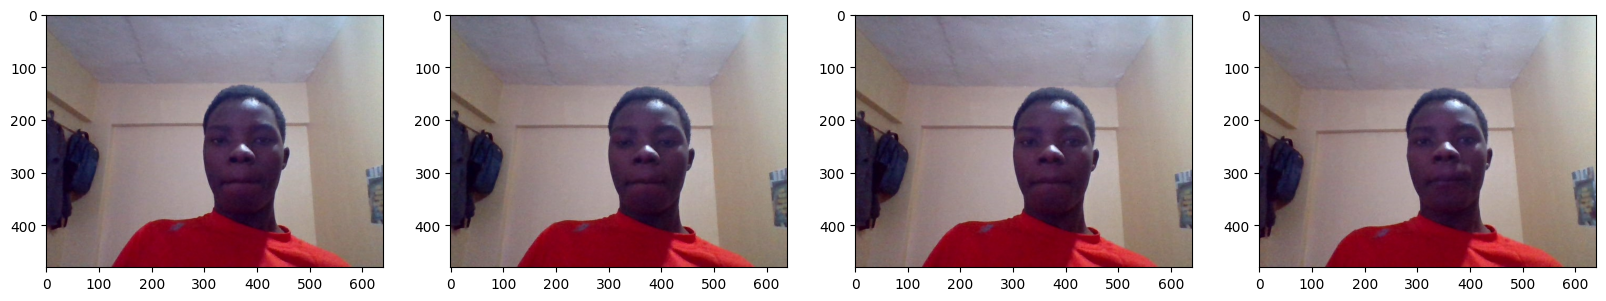

In [23]:
# View images
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()


Partition Unaugmented Data